## AutoGluonImputer

This package offers a sophisticated solution for handling missing data in datasets using the AutoGluon TabularPredictor. It's adept at working with both numerical and categorical data and provides a machine-learning-driven approach for imputation.


In [152]:
#!pip install --upgrade pandas numpy scikit-learn autogluon
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from autogluon.tabular import TabularDataset
from scripts.autogluonImputer import Imputer 
import importlib


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
# get help about Imputer
help(Imputer)

# print the content of Imputer
import inspect
print(inspect.getsource(Imputer))

Help on class Imputer in module scripts.autogluonImputer:

class Imputer(builtins.object)
 |  Imputer(num_iter=10, time_limit=60, presets=['medium_quality', 'optimize_for_deployment'], column_settings=None, use_missingness_features=False, simple_impute_columns=[])
 |  
 |  Methods defined here:
 |  
 |  __init__(self, num_iter=10, time_limit=60, presets=['medium_quality', 'optimize_for_deployment'], column_settings=None, use_missingness_features=False, simple_impute_columns=[])
 |      Imputer leveraging AutoGluon for predictive imputation of missing data.
 |      
 |      Uses separate AutoGluon models for each column with missing values to predict and impute based on other columns.
 |      
 |      Parameters
 |      ----------
 |      num_iter : int, optional (default=10)
 |          Number of iterations for the imputation process.
 |      
 |      time_limit : int, optional (default=60)
 |          Time in seconds for each individual model training during the imputation.
 |      
 

#### Step 2: Prepare the Data


In [154]:

# Load the data
X, y = fetch_openml(
    "titanic", version=1, as_frame=True, return_X_y=True, parser="pandas"
)

# combine X and y in one dataframe
df=X.copy()
df['target']=y
df.head()
# drop name and ticket

df.drop(['name','ticket'],axis=1,inplace=True)


In [155]:
df=TabularDataset(df)
df.dtypes
# convert object to category
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=df[col].astype('category')

# convert integer to float
for col in df.columns:
    if df[col].dtype=='int64':
        df[col]=df[col].astype('float64')

df.dtypes


pclass        float64
sex          category
age           float64
sibsp         float64
parch         float64
fare          float64
cabin        category
embarked     category
boat         category
body          float64
home.dest    category
target       category
dtype: object

In [156]:

# Split the data into train and test sets
train, test = train_test_split(df, test_size=0.3, random_state=42)

# Introduce missingness
train_missing = train.mask(np.random.random(train.shape) < 0.2)
test_missing = test.mask(np.random.random(test.shape) < 0.2)


## Step 3: Impute Missing Values

In [157]:
imputer = Imputer(num_iter=2, time_limit=5)
train_imputed = imputer.fit(train_missing)
test_imputed = imputer.transform(test_missing)


No path specified. Models will be saved in: "AutogluonModels/ag-20231030_154358/"


Fitting the imputer to the data...


No path specified. Models will be saved in: "AutogluonModels/ag-20231030_154404/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231030_154409/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231030_154417/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231030_154423/"
		ray::_ray_fit() (pid=76459, ip=127.0.0.1)
  File "/Users/denizakdemir/.pyenv/versions/3.10.0/envs/DataScienceEnv_Autoencoder/lib/python3.10/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 402, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold, time_limit=time_limit_fold, **resources, **kwargs_fold)
  File "/Users/denizakdemir/.pyenv/versions/3.10.0/envs/DataScienceEnv_Autoencoder/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 829, in fit
    out = self._fit(**kwargs)
  File "/Users/denizakdemir/.pyenv/versions/3.10.0/envs/DataScienceEnv_Autoencoder/lib/python3.

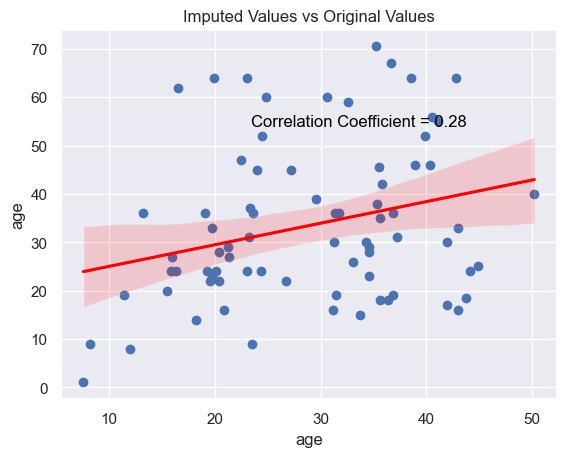

In [158]:
# Compare imputed values with original values for the target variable
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Identify missing indices in test dataset
missing_indices_test = test_missing['age'].index[test_missing['age'].apply(np.isnan)]

# Plot imputed values against original values
plt.scatter(test_imputed['age'][missing_indices_test], test['age'][missing_indices_test])
plt.xlabel('Imputed Values')
plt.ylabel('Original Values')
plt.title('Imputed Values vs Original Values')
sns.regplot(x=test_imputed['age'][missing_indices_test], y=test['age'][missing_indices_test], scatter=False, color='red')
# Calculate and display the correlation coefficient
# put test_imputed['age'][missing_indices_test], test['age'][missing_indices_test] in a dataframe
df=pd.DataFrame({'imputed':test_imputed['age'][missing_indices_test], 'original':test['age'][missing_indices_test]})
# remove rows with missing values
df=df.dropna()
# calculate correlation coefficient
corr = np.corrcoef(df['imputed'], df['original'])[0,1]
plt.text(.6, .75, f'Correlation Coefficient = {round(corr, 2)}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='black')
plt.show()

In [159]:
test_imputed.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest,target
1148,3.0,male,35.000000,0.0,0.0,19.077435,F2,S,15,123.588165,"New York, NY",0
1049,3.0,male,15.498122,0.0,1.0,15.741700,D38,C,C,126.847885,"England Brooklyn, NY",1
982,3.0,male,42.980644,0.0,0.0,7.895800,A36,S,15,115.922722,"Oslo, Norway Cameron, WI",0
808,3.0,male,41.903778,0.0,0.0,10.316036,F2,S,9,123.588165,London,0
1195,3.0,male,35.868683,0.0,0.0,7.750000,F38,Q,9,115.922722,"Ireland New York, NY",0


In [160]:
imputer.evaluate_imputation(train, percentage=.2, ntimes=3)


{0: {'pclass': {'mse': 0.273224043715847, 'mae': 0.18579234972677597},
  'sex': {'accuracy': 0.7431693989071039},
  'age': {'mse': 149.31137150514618, 'mae': 9.790158390176707},
  'sibsp': {'mse': 1.1912568306010929, 'mae': 0.44808743169398907},
  'parch': {'mse': 1.7923497267759563, 'mae': 0.9398907103825137},
  'fare': {'mse': 833.6507831826189, 'mae': 18.367499136824687},
  'cabin': {'accuracy': 0.425},
  'embarked': {'accuracy': 0.7103825136612022},
  'boat': {'accuracy': 0.07692307692307693},
  'body': {'mse': 21341.16895835455, 'mae': 120.64605174345128},
  'home.dest': {'accuracy': 0.4215686274509804},
  'target': {'accuracy': 0.819672131147541}},
 1: {'pclass': {'mse': 0.30601092896174864, 'mae': 0.22950819672131148},
  'sex': {'accuracy': 0.7595628415300546},
  'age': {'mse': 195.08258243731683, 'mae': 10.62593170284929},
  'sibsp': {'mse': 0.8579234972677595, 'mae': 0.3551912568306011},
  'parch': {'mse': 0.8415300546448088, 'mae': 0.4918032786885246},
  'fare': {'mse': 1143.

# multiple imputation

In [161]:
from scripts.autogluonImputer import multiple_imputation
num_iter=2
time_limit=10
train_imputed = multiple_imputation(train_missing, n_imputations=10, num_iter=num_iter, time_limit=time_limit, fitonce=True)


No path specified. Models will be saved in: "AutogluonModels/ag-20231030_154723/"


Fitting the model once and imputing multiple times...
Fitting the imputer to the data...


No path specified. Models will be saved in: "AutogluonModels/ag-20231030_154735/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231030_154747/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231030_154759/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231030_154811/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231030_154827/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231030_154838/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231030_154850/"
		ray::_ray_fit() (pid=77204, ip=127.0.0.1)
  File "/Users/denizakdemir/.pyenv/versions/3.10.0/envs/DataScienceEnv_Autoencoder/lib/python3.10/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 402, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold, time_limit=time_limit_fold, **resources, **kwargs_fold)
  File "/Users/denizakdemir/.pyenv/versions/3.10.0/envs/Dat

Performing imputation 1/10
Performing imputation 2/10
Performing imputation 3/10
Performing imputation 4/10
Performing imputation 5/10
Performing imputation 6/10
Performing imputation 7/10
Performing imputation 8/10
Performing imputation 9/10
Performing imputation 10/10


In [162]:
train_imputed[0].head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest,target
1214,3.0,male,30.166594,0.0,0.0,8.6625,F2,S,13,112.348961,"Auburn, NY",0
677,3.0,male,26.000000,0.0,0.0,7.8958,F33,S,13,167.498947,"Bulgaria Chicago, IL",0
534,2.0,female,19.000000,0.0,0.0,26.0000,B42,S,11,162.699020,"Worcester, England",1
1174,3.0,female,22.142212,8.0,2.0,69.5500,C23 C25 C27,S,15,155.461243,"Sweden Worcester, MA",1
864,3.0,female,28.201103,0.0,0.0,7.7750,F33,S,13,116.504128,"Cornwall / Spokane, WA",0


In [163]:
train_imputed[1].head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest,target
1214,3.0,male,30.968981,0.0,0.0,8.6625,F2,S,13,69.473015,"Cornwall / Spokane, WA",0
677,3.0,male,26.000000,0.0,0.0,7.8958,F2,S,13,136.165237,"Bulgaria Chicago, IL",0
534,2.0,female,19.000000,0.0,0.0,26.0000,F2,S,11,131.323853,"Worcester, England",1
1174,3.0,female,17.342199,8.0,2.0,69.5500,C22 C26,S,15,99.102478,"Wiltshire, England Niagara Falls, NY",0
864,3.0,female,27.994289,0.0,0.0,7.7750,F33,S,13,116.504128,"Cornwall / Spokane, WA",0


In [164]:
train_imputed[1].dtypes

pclass        float64
sex          category
age           float64
sibsp         float64
parch         float64
fare          float64
cabin        category
embarked     category
boat         category
body          float64
home.dest    category
target       category
dtype: object